In [40]:
import sqlite3
import pandas as pd
import ast
import numpy as np
import missingno as msno

## Extract Tables from the Database

In [28]:
# Establish a database connection
con = sqlite3.connect("cademycode.db")
cur = con.cursor()

# Read table names
table_list = [x for x in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table';")]
print(table_list)

[('cademycode_students',), ('cademycode_courses',), ('cademycode_student_jobs',)]


In [29]:
# Extract tables from db file
students = pd.read_sql_query("SELECT * FROM cademycode_students", con)
courses = pd.read_sql_query("SELECT * FROM cademycode_courses", con)
student_jobs = pd.read_sql_query("SELECT * FROM cademycode_student_jobs", con)

## Clean the Data

### 'students' table

In [8]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64


In [9]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


Students table has the following points of note:
- 'dob' needs to be changed to a datetime object.
- 'contact_info' is a dictionary. It requires to be pivoted/exploded into separate columns.
- 'num_course_taken' and 'time_spent_hrs' should be changed to numerical datatypes (integer and float, respectively). 
- 'job_id' and 'current_career_path_id' should be treated as categorical data. 
- There are null values in 'job_id', 'num_course_taken', 'current_career_path_id', and 'time_spent_hrs'. 

#### Changing to a datetime object

In [30]:
students['dob'] = pd.to_datetime(students['dob'])

In [31]:
# Creating 'age' column
students['age'] = (pd.to_datetime('now') - students['dob']).astype('<m8[Y]').astype(int)

C:\Users\seren\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:2224: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [20]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99,80
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4,32
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74,33
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31,35
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64,60


In [21]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    5000 non-null   int64         
 1   name                    5000 non-null   object        
 2   dob                     5000 non-null   datetime64[ns]
 3   sex                     5000 non-null   object        
 4   contact_info            5000 non-null   object        
 5   job_id                  4995 non-null   object        
 6   num_course_taken        4749 non-null   object        
 7   current_career_path_id  4529 non-null   object        
 8   time_spent_hrs          4529 non-null   object        
 9   age                     5000 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(7)
memory usage: 371.2+ KB


#### Exploding the dictionary

In [32]:
students['contact_info'] = students['contact_info'].apply(lambda x: ast.literal_eval(x))
explode_contact_info = pd.json_normalize(students['contact_info'])
students = pd.concat([students.drop('contact_info', axis=1), explode_contact_info], axis=1)

In [33]:
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,mailing_address,email
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,80,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,32,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,35,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,60,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com


#### Changing datatypes

Datatypes of the following columns are changed to floats as some of them cannot be casted as integers due to null values.

In [35]:
students['job_id'] = students['job_id'].astype(float)
students['num_course_taken'] = students['num_course_taken'].astype(float)
students['current_career_path_id'] = students['current_career_path_id'].astype(float)
students['time_spent_hrs'] = students['time_spent_hrs'].astype(float)

In [36]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    5000 non-null   int64         
 1   name                    5000 non-null   object        
 2   dob                     5000 non-null   datetime64[ns]
 3   sex                     5000 non-null   object        
 4   job_id                  4995 non-null   float64       
 5   num_course_taken        4749 non-null   float64       
 6   current_career_path_id  4529 non-null   float64       
 7   time_spent_hrs          4529 non-null   float64       
 8   age                     5000 non-null   int32         
 9   mailing_address         5000 non-null   object        
 10  email                   5000 non-null   object        
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(4)
memory usage: 410.3+ KB


#### Handling Null values

In [37]:
# Quick analysis into the amount of missing data using pandas
students.describe()

,uuid,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age
count,5000.000000,4995.000000,4749.000000,4529.000000,4529.000000,5000.000000
mean,2500.500000,4.172172,7.533586,5.478914,11.520625,50.179600
std,1443.520003,2.148098,4.609884,2.874135,7.564228,18.321345
min,1.000000,1.000000,0.000000,1.000000,0.000000,18.000000
25%,1250.750000,2.000000,4.000000,3.000000,5.380000,35.000000
50%,2500.500000,4.000000,7.000000,5.000000,10.670000,50.000000
75%,3750.250000,6.000000,12.000000,8.000000,16.750000,66.000000
max,5000.000000,8.000000,15.000000,10.000000,35.980000,81.000000


In [38]:
students.isna().sum()

uuid                        0
name                        0
dob                         0
sex                         0
job_id                      5
num_course_taken          251
current_career_path_id    471
time_spent_hrs            471
age                         0
mailing_address             0
email                       0
dtype: int64

<AxesSubplot:>

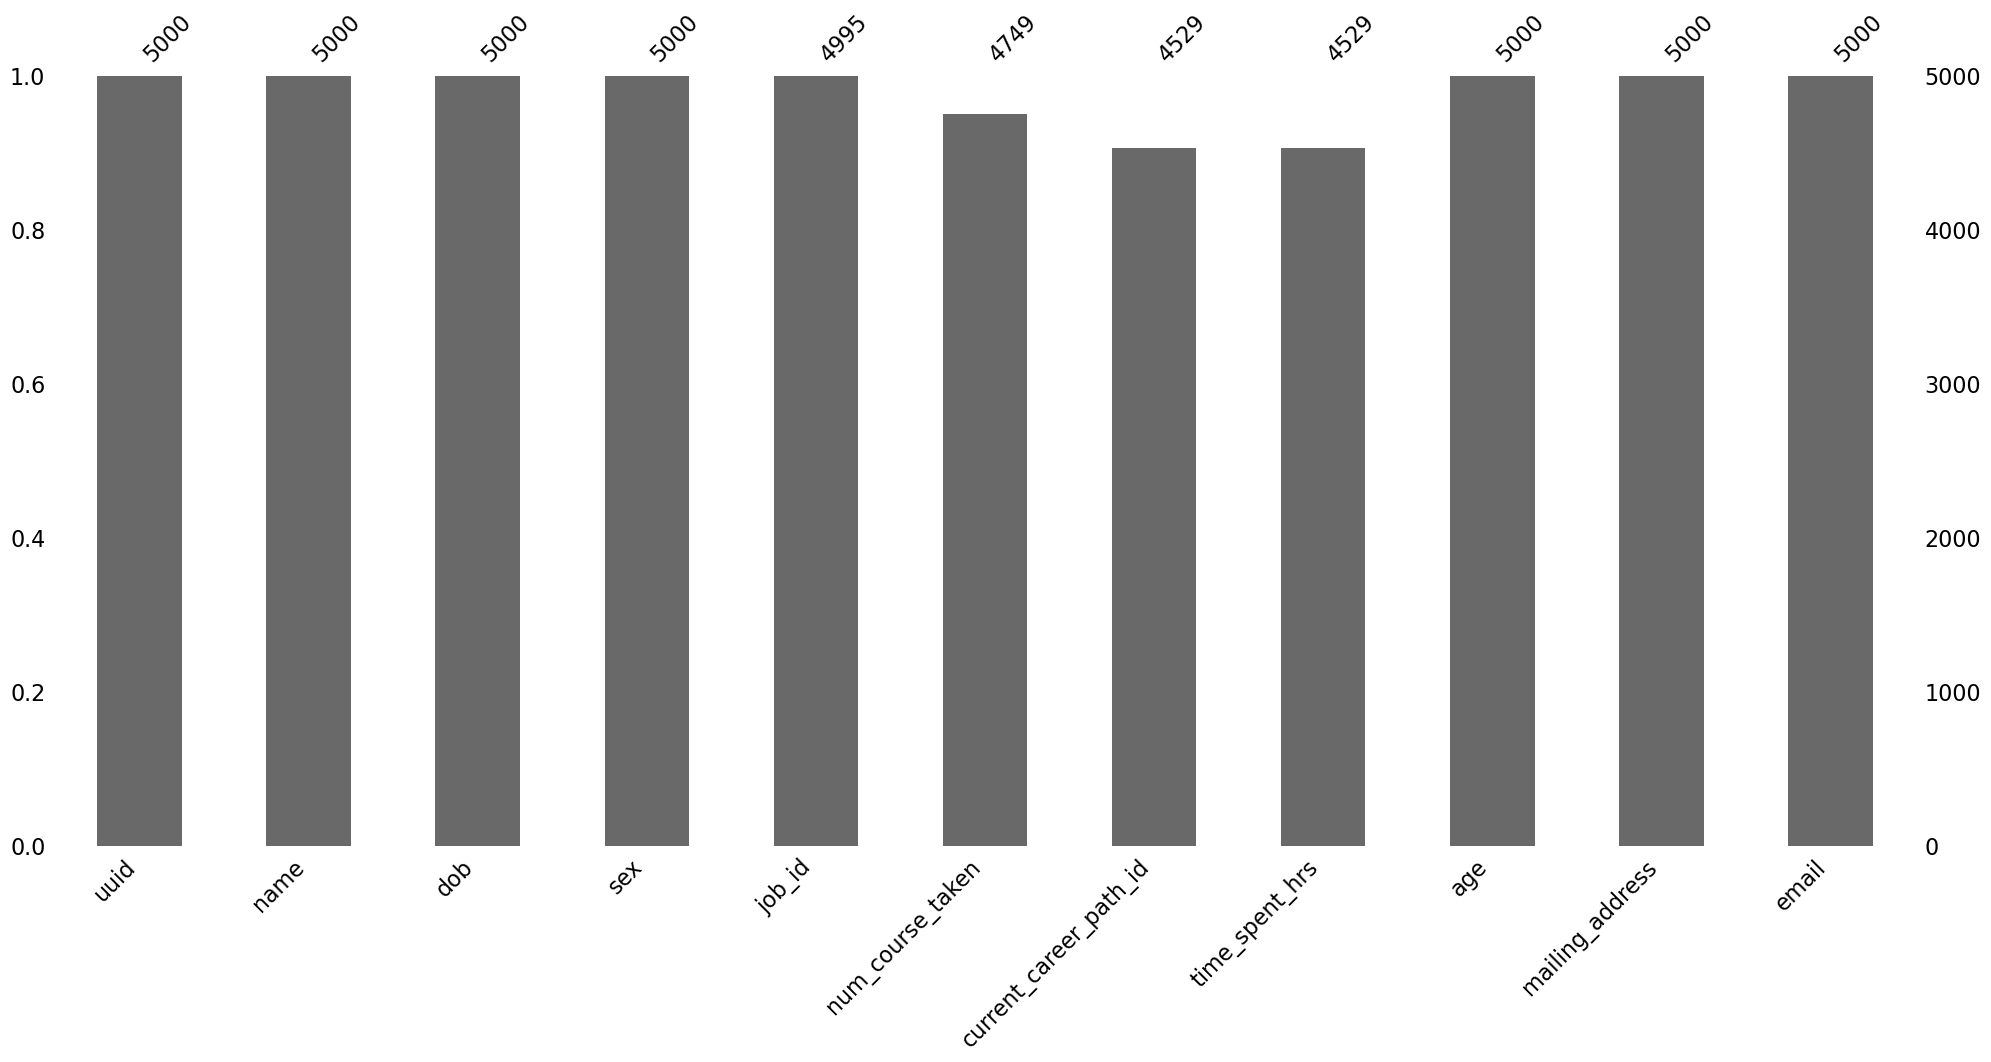

In [41]:
# Visualizing the amount of missing values for each variable
msno.bar(students)

The bar chart above visualizes the degree of missingness in each feature. 'job_id' is missing less than 1 percent. 'current_career_path_id' and 'time_spend_hrs' have the same number of missing values. 

<AxesSubplot:>

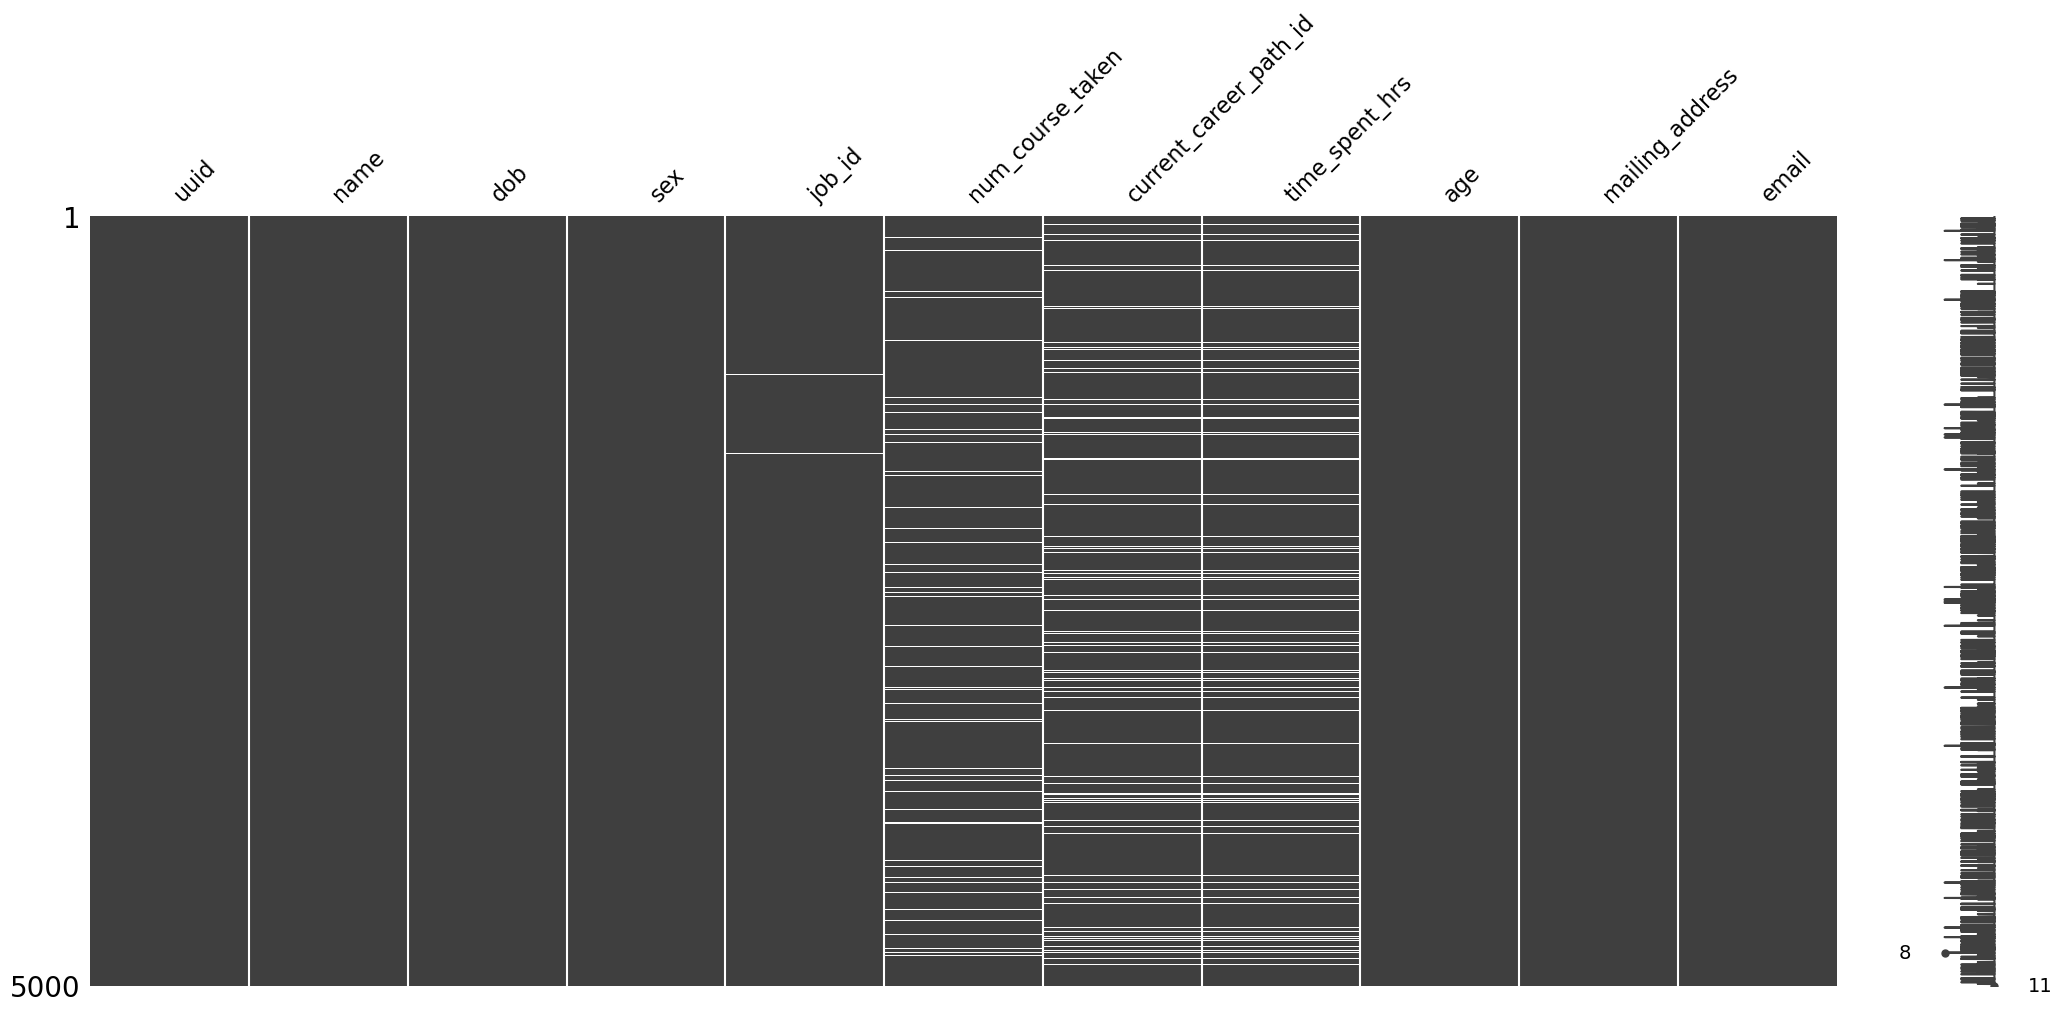

In [44]:
# Visualizing the distribution of missing values for each variable
msno.matrix(students)

The missing values in 'job_id' and 'num_course_taken' do not appear correlated with other missing values. This might be a case of MAR, as there might be a reason for the missing values that cannot be directly observed. On the other hand, the pattern of missingness is similar for 'current_career_path_id' and 'time_spent_hrs', which may signal that they are structually missing. 

<AxesSubplot:>

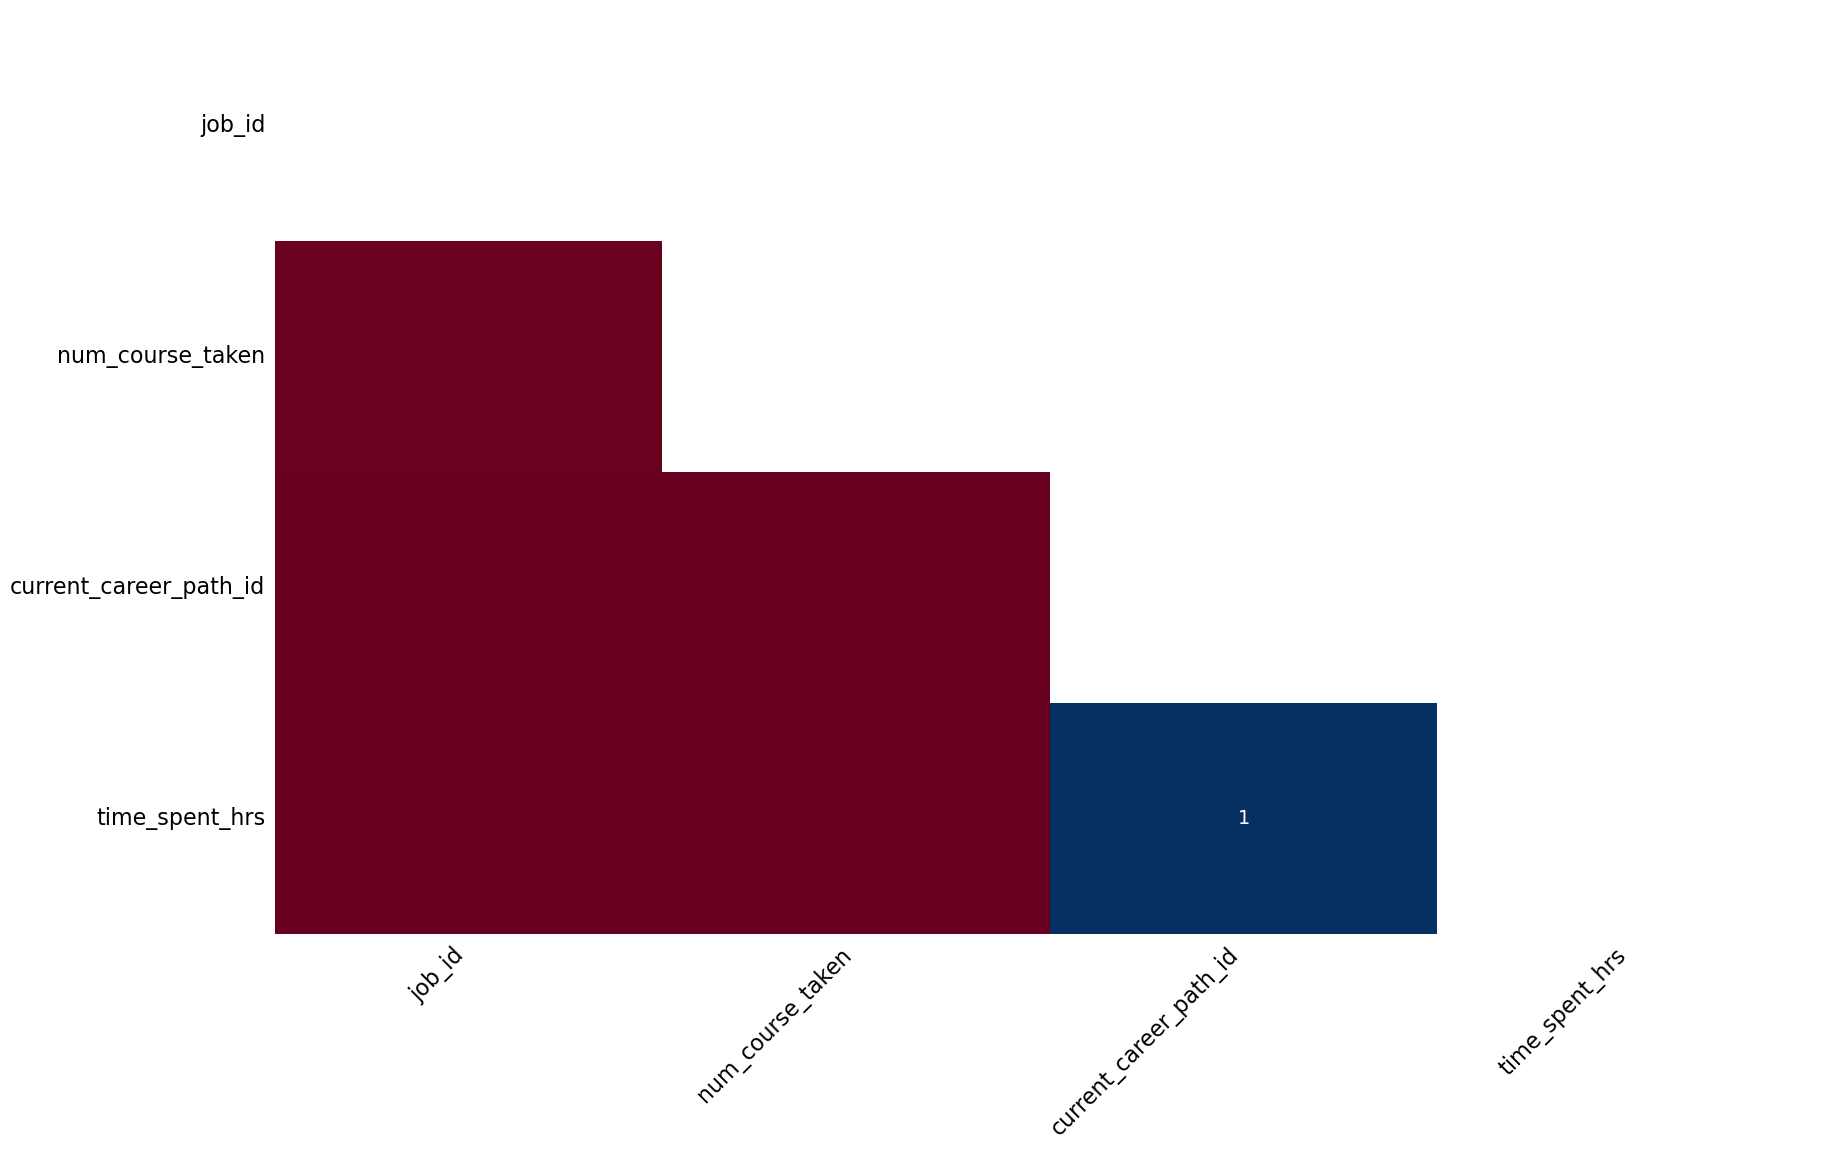

In [43]:
msno.heatmap(students)

In summary, the findings about missing values and strategies to resolve them are as follow:
- 'job_id' is likely a MAR and is missing only 5 rows. A listwise deletion of missing values is to be performed.
- Similarly, 'num_course_taken' appears to be MAR and is missing less than 5% of the data. A listwise deletion is to be performed.
- We suspect that 'current_career_path_id' and 'num_course_taken' are structurally missing. To resolve this, missing values in 'current_career_path_id' is to be set as a new id to indicate no current career path. The missing values in 'time_spent_hrs' is to be set as 0 to indicate no hours spent. 

In [45]:
# Listwise deletion of missing values in 'job_id' & 'num_course_taken'
students = students.dropna(subset=['job_id'])
students = students.dropna(subset=['num_course_taken'])

In [48]:
# Setting missing values in 'current_career_path_id' and 'num_course_taken'
students['current_career_path_id'] = np.where(students['current_career_path_id'].isnull(), 0, students['current_career_path_id'])
students['time_spent_hrs'] = np.where(students['time_spent_hrs'].isnull(), 0, students['time_spent_hrs'])

Now that null-values are handled, the datatypes of the features regarding id ('job_id', 'current_career_path_id') are to be changed as integers.

In [65]:
# From floats to integers
students['job_id'] = students['job_id'].astype(int)
students['current_career_path_id'] = students['current_career_path_id'].astype(int)

In [66]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4744 non-null   int64         
 1   name                    4744 non-null   object        
 2   dob                     4744 non-null   datetime64[ns]
 3   sex                     4744 non-null   object        
 4   job_id                  4744 non-null   int32         
 5   num_course_taken        4744 non-null   float64       
 6   current_career_path_id  4744 non-null   int32         
 7   time_spent_hrs          4744 non-null   float64       
 8   age                     4744 non-null   int32         
 9   mailing_address         4744 non-null   object        
 10  email                   4744 non-null   object        
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1), object(4)
memory usage: 389.2+ KB


### 'courses' table

In [53]:
courses.head(10)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [52]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   career_path_id     10 non-null     int64 
 1   career_path_name   10 non-null     object
 2   hours_to_complete  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 368.0+ bytes


Following the change in 'current_career_path' variable in the students table, 'career_path_id' = 0 as null values need to be added to the database.

In [55]:
# Setting N/A = 0
not_applicable = {'career_path_id': 0,
                  'career_path_name': 'not applicable',
                  'hours_to_complete': 0}
courses.loc[len(courses)] = not_applicable
courses.head(11)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [ ]:
# 

### students_jobs table

In [60]:
student_jobs.head(13)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


In [59]:
student_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        13 non-null     int64 
 1   job_category  13 non-null     object
 2   avg_salary    13 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 440.0+ bytes


In [64]:
student_jobs.drop_duplicates(inplace=True)
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


## Join the Tables

In [68]:
fianl_df = students.merge(courses, left_on='current_career_path_id', right_on='career_path_id', how='left')
final_df = fianl_df.merge(student_jobs, on = 'job_id', how = 'left')
final_df.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,mailing_address,email,career_path_id,career_path_name,hours_to_complete,job_category,avg_salary
0,1,Annabelle Avery,1943-07-03,F,7,6.0,1,4.99,80,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com,1,data scientist,20,HR,80000
1,2,Micah Rubio,1991-02-07,M,7,5.0,8,4.40,32,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com,8,android developer,27,HR,80000
2,3,Hosea Dale,1989-12-07,M,7,8.0,8,6.74,33,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com,8,android developer,27,HR,80000
3,4,Mariann Kirk,1988-07-31,F,6,7.0,9,12.31,35,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com,9,machine learning engineer,35,education,61000
4,5,Lucio Alexander,1963-08-31,M,7,14.0,3,5.64,60,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com,3,data analyst,12,HR,80000


In [69]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4743
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4744 non-null   int64         
 1   name                    4744 non-null   object        
 2   dob                     4744 non-null   datetime64[ns]
 3   sex                     4744 non-null   object        
 4   job_id                  4744 non-null   int32         
 5   num_course_taken        4744 non-null   float64       
 6   current_career_path_id  4744 non-null   int32         
 7   time_spent_hrs          4744 non-null   float64       
 8   age                     4744 non-null   int32         
 9   mailing_address         4744 non-null   object        
 10  email                   4744 non-null   object        
 11  career_path_id          4744 non-null   int64         
 12  career_path_name        4744 non-null   object  

In [70]:
con.close()

## Upsert cleansed data table to a new SQLite DB

In [71]:
con = sqlite3.connect('cademycode_cleansed.db')
final_df.to_sql('cademycode_aggregated', con, if_exists='replace', index=False)

4744

In [72]:
db_df = pd.read_sql_query("SELECT * FROM cademycode_aggregated", con)

In [73]:
db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   int64  
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   int64  
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   int64  
 9   mailing_address         4744 non-null   object 
 10  email                   4744 non-null   object 
 11  career_path_id          4744 non-null   int64  
 12  career_path_name        4744 non-null   object 
 13  hours_to_complete       4744 non-null   int64  
 14  job_category            4744 non-null   

In [74]:
# to csv
db_df.to_csv('cademycode_cleansed.csv')

In [75]:
con.close()